In [1]:
import pandas as pd
import json
from evaluation_utils import read_global_results, ssl_method_to_category, unpivot_ssl_model, unpivot_baseline_model, read_processed_shards
from constants import RESULTS_ROOT, PRELIMINARY_DIR, MODE_1_PROCESSED_DIR, MODE_2_3_MARG_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, MODE_1_LEARNING_CURVES_DIR, model_abbreviations
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
import itertools
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.colors import ListedColormap
from itertools import zip_longest
from os.path import join
from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib.patches import Polygon
from sklearn.metrics import silhouette_score

In [2]:
df = read_processed_shards(MODE_2_3_MARG_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
17.ndjson
18.ndjson
19.ndjson
20.ndjson
21.ndjson
22.ndjson
23.ndjson
24.ndjson
25.ndjson
26.ndjson
27.ndjson
28.ndjson
29.ndjson
30.ndjson
31.ndjson
32.ndjson
33.ndjson
34.ndjson
35.ndjson
36.ndjson
concatenating


In [3]:
# SSL results
df_ssl = unpivot_ssl_model(df=df, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES,  include_graph_params=True)
df_baseline = unpivot_baseline_model(df=df, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES, include_graph_params=True)

## Appendix plots
#### For all graph paramters:
- The fixed parameters seems to make the default graphs harder than the graphs sampled for the global results. This is most obvious in the parameters which seem to have little influence on performance, such as cluster_size_slope, where most points on the line is below the results reported in the global results table.
- Comment on baselines for each graph parameter

#### Avg degree:
- Show plots for:
    - CER (general trends), CFR (difference for GIN, URL), S-PPR (trend for PPR), MVMI-FT (always good), SUBGCON (very good when low)
    - Ranks
- Encoders:
    - The performance of GCN and GIN gets worse with higher avg degree no matter the training scheme for most SSL methods. This is also the case for GAT URL
    - For GAT trained wth JL or PF, most models either maintain their performance or increase it with higher avg degree. GAT generally performs best for higher degrees.
- Training schemes:
    - Most models seem to prefer JL or PF in the overall case (as seen in global)
    - There is generally not a big difference in how the avg degree affects the training schemes, but with (GAT, URL) we see that the performance degrades with higher degrees while GAT with JL or PF generally improves the performance 
- Specific observations for methods / categories:
    - CFR is one method that across all encoders prefer the URL training scheme. Interestingly (URL, GIN) has a very strong performance for low degrees, indicating that for some graphs a GIN encoder may be preferred. However, GAT takes over for higher degrees even for this method.
    - Methods that use PPR diffusion on the augmentated graphs are generally much less affected by the avg degree. In addition, these methods are the only ones where the performance of the GCN encoders increase when the degree is higher. This could suggest that topology augmentations that utilize diffusion strategies to add edges with a contrastive loss, are generally robust, but perform even better if the original graph has more edges. 
    - MVMI-FT does not seem to be affected by the avg degree at all. It is hard to pinpoint why this is the case, as this is by far the most complex method with many possible interactions. As MVMI-FT is always top performing no matter the avg degree, it suggests that it is robust to the amount of edges in the graph.
    - SUBGCON is really good for low degrees but quickly fails at higher degrees


#### Cluster size slope:
- Show plots for:
    - ranks
- This property has little to no effect on the results, so we skip past it.
    - There is no new information to gain from this, that can't be gained from global results


#### Feature center distance:
- Show plots for:
    - CER (general trends),  CFR (difference in GIN, URL),  SUBG-CON (followup on the method being good + better robustness to value)
    - ranks
- General:
    - For all models, the performance increases when the property increases. Hence there are no difference in the reaction to the property, just how the models benefit as the property increases.
- Encoders:
    - There is generally no big differences in how GAT and GCN react to the property. For most methods GAT and GCN is almost indistinguishable. GIN seem to benefit the least as the property increases.
- Training schemes:
    - There is no big differences in how the training scheme is affected by the property. However, for most methods JL and PF seem to benefit the most 
- Specific observations for methods / categories:
    - For CFR benefits the most in (GIN, URL) - in fact much more than its other models. Notice that NC also seem to benefit from GIN in the URL and JL training schemes.
    - It is clear for MEtAl that it benefits the most for (GAT, JL)
    - A few methods (MVMI-FT, NC, G-Zoom, and SUBG-CON) seem much more robust to the property value, as they show high performance even when it is quite low.


#### min deg:
- Show plots for:
    - ranks
- This property has little to no effect on the results, so we skip past it
    - Note that the performance for most models seem to slightly decrease as the min degree encreases, but this is likely due to weirdness of the generator


#### num clusters:
- Show plots for:
    -  S-Split (general statements), GCA (GAT strong early), SUBG-CON (increasing performance / stable), CFR (GIN able to do good)
    - ranks 
- Generally the performance of most models decrease as the number of clusters increase. This makes sense as the number of clusters makes the classification problem harder. Hence when evaluating this property, we are interested in knowing how robust the methods are to the it, I.e. maybe some methods are only good at distuingishing between few labels, whereas others benefit from multiple clusters if it firts the pretext task
- Encoders:
    - While GCN and GAT performs much better in most cases, the performance for all encoders seem to drop the same for most models. However, GCN does not seem to drop as much with URL compared to GAT and GIN.
    - For a few methods, GAT performs quite a lot better for a low number of clusters, but when the number of clusters increase, GAT starts to look similar to GCN
- Training schemes:
    - JL and PF is again the most stable and overall best. With URL training, the performance tend to decrease much more when the number of clusters gets high.
- Specific observations for methods / categories:
    - The methods that tend to be the best, perform well also for large number of clusters. I.e. the performance does not degrade very much, and in some cases actually increase. This can be seen in the PPR methods, hybrid methods and SUBG-CON
    - MEtAl shows that beside for PF, GIN performs better than GCN across pretty much all values of the property. In addition, both GAT and GIN actually gets better performance as the number of clusters increase
    - Once again CFR is really good with GIN URL, where the performance do not really decrease


#### nvertex
- Show plots for:
    - S2GRL (general trends), MEtAl(good methods not reacting, + encoder difference), AM (different reaction in training schemes)
    - ranks
- Generally, most models seem to benefit from more nodes - even the baselines.  This is different from GraphWorld, where they claim the vertices have neglible effect on the performance. However, note that the overall performance gain is still quite small, where the average model performance only seem to increase with 2 in the ROC score when spanning the full range of vertices. The methods already are topperforming however, seems to benefit less from this.
- Encoders:
    - For most methods the encoders seem to be reacting the same to the property.
    - In some methods they do react differenly, where one encoder might increase in performance while another decreases. This is most visible in MEtAl and CFR.
- Training schemes:
    - As with the other properties URL lacks behind JL and PF for most methods. However, for many of the methods the slope of the lines seem similar.
    - And as usual CFR is one of the outliers where the URL training scheme is prefered. However, note that for GIN URL, while it is the best for this method, the performance actually decreases with the number of nodes increasing
- Specific observations for methods / categories:
    - None that are not already mentioned

#### p to q ratio
- Show plots for:
    - S2GRL (general trends), AM (for high values the performance is similar), CFR (GIN URL + good performing models reacting way less)
    - ranks
- Generally all model benefit from a higher p to q ratio, which makes sense. However, the really strong performing methods do not react to it very much (or at all). For this property, the performance for most methods seem to be spread out the most when the p to q is low, while the encoders/training schemes seem to be moving towards similar peformances with it the property is high (with GIN URL being a common exception). This could indicate that when the p to q ratio is really high, then the performance differences between the encoders/training schemes does not really matter, as the classification problem is just that easy. Hence the most interesting part of this property, is to see how robust the different models are at the lower values, to see which models perform the best when the classification problem is hard.
- Encoders
    - Similar to other properties, the encoders seem to react the same to p to q
    - In general GIN has lower performance, with the usual exceptions (CFR)
- Training schemes
    - The usual things can be said about the training schemes: JL & PF performing the best.
    - However, note that as the p to q ratio increases, the gap between the training schemes tend to smooth out, with (GIN, URL) being the common exception.
- Specific observations for methods / categories:
    - GIN URL for CFR seems very robust to the property, with high performance even when it is low.
    - There is generaly no big overtakes, where as the property shifts one encoder/training scheme takes over.
    - The good performing methods and PPR methods seem to be more robust to low values of p to q, either having the property not affect them or only very little.

#### power exponent
- Show plots for:
    - ranks
- Generally all model benefit slightly from a higher power exponent, suggest that graphs with a degree distribution that follows a powerlaw may perform better. However, on average the peformance increase for most models are just 2 when going from the lowest value of the property to the highest value. When examining the rank plots the ranks do also not move very much, indicatng that a comparison of the different methods are not very much affected by this property. Hence we will not go into details with cherry picked plots.
- Encoders:
    - Similar thing to say as previous properties
- Training schemes:
    - Similar thing to say as previous properties
- Specific observations for methods / categories:
    - Similar outliers as for previous properties
    - In general the best performing models react way less to the property

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


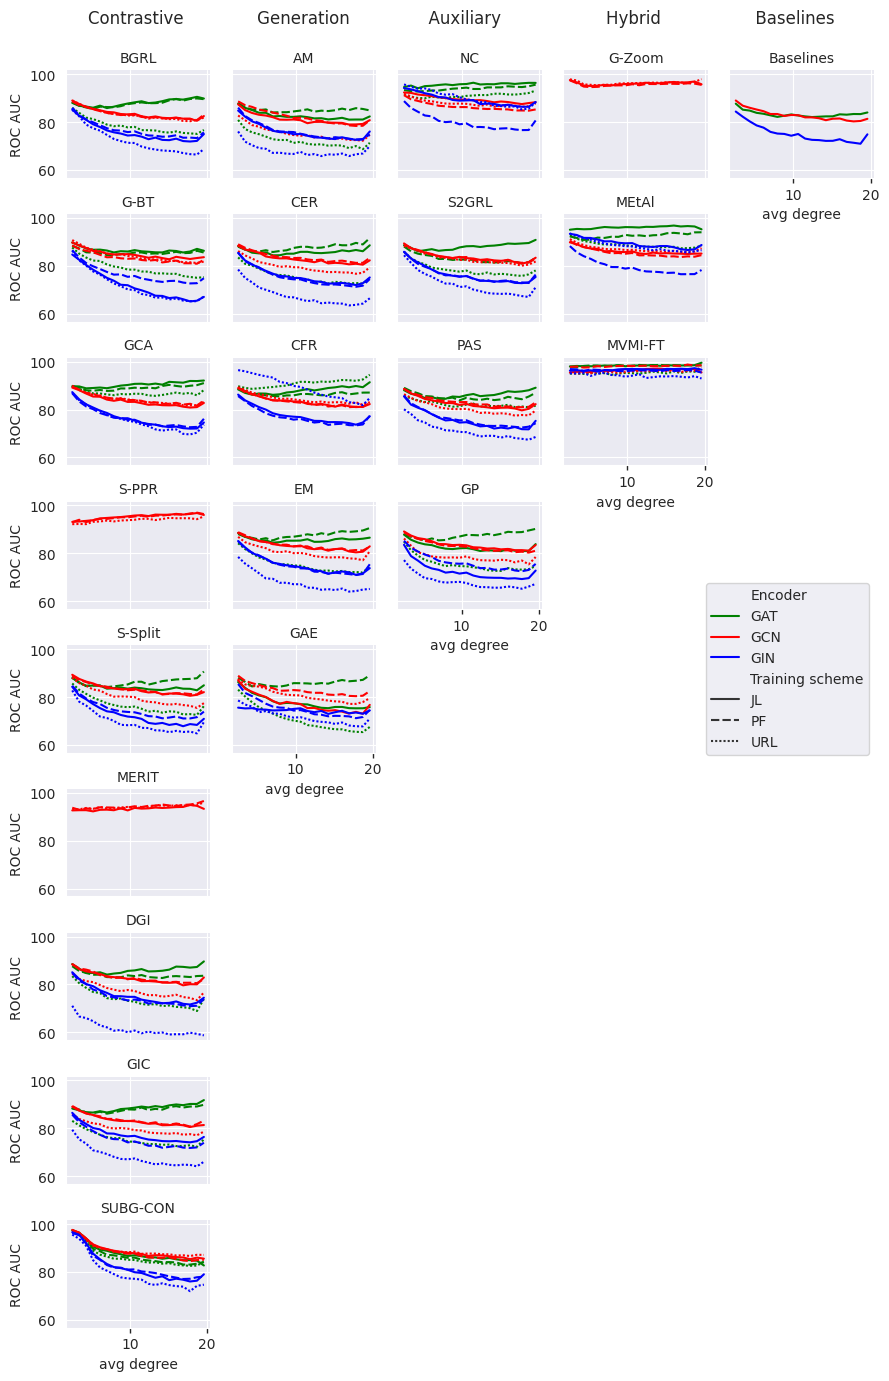

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


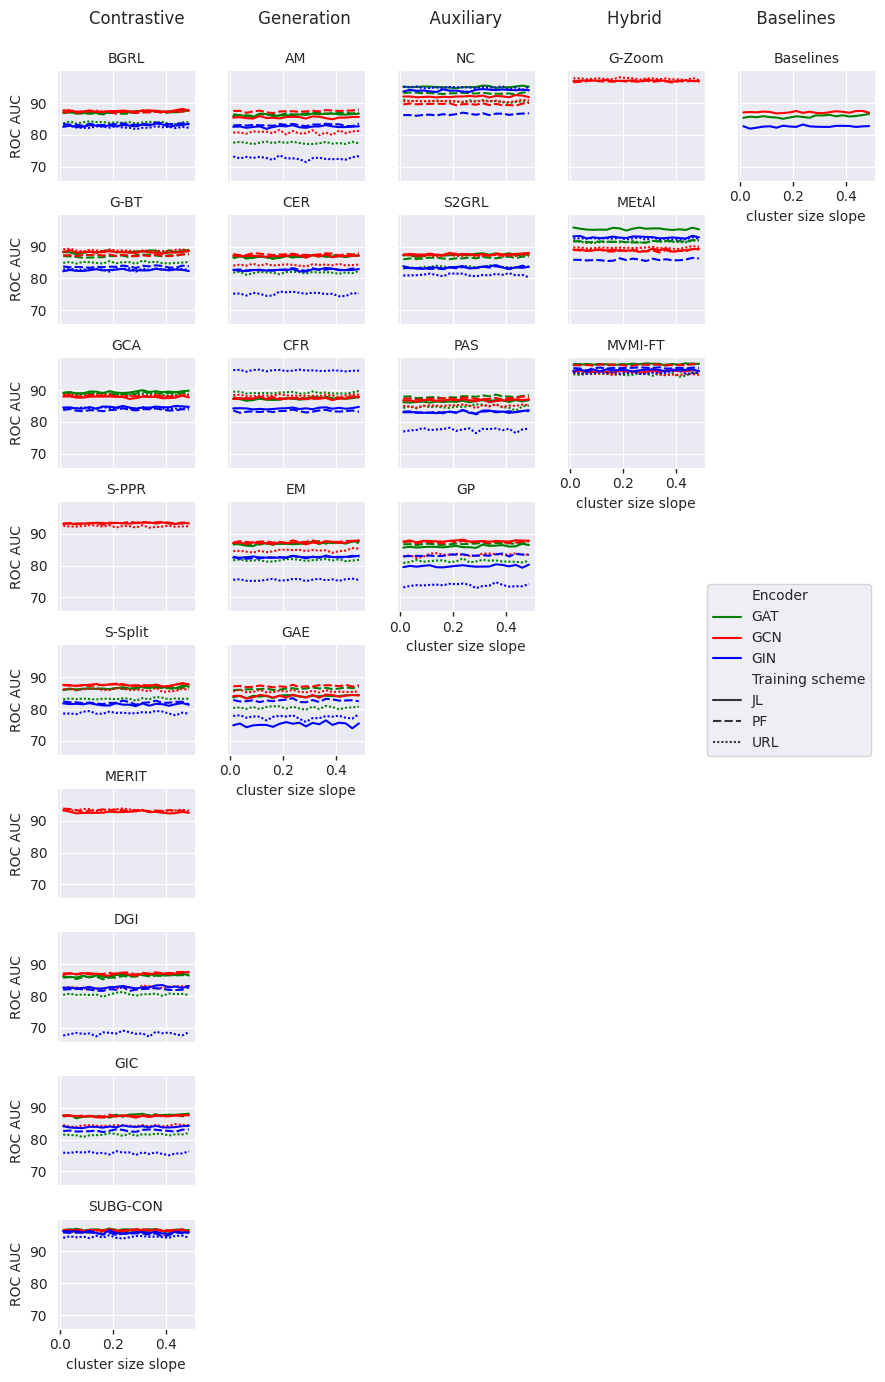

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


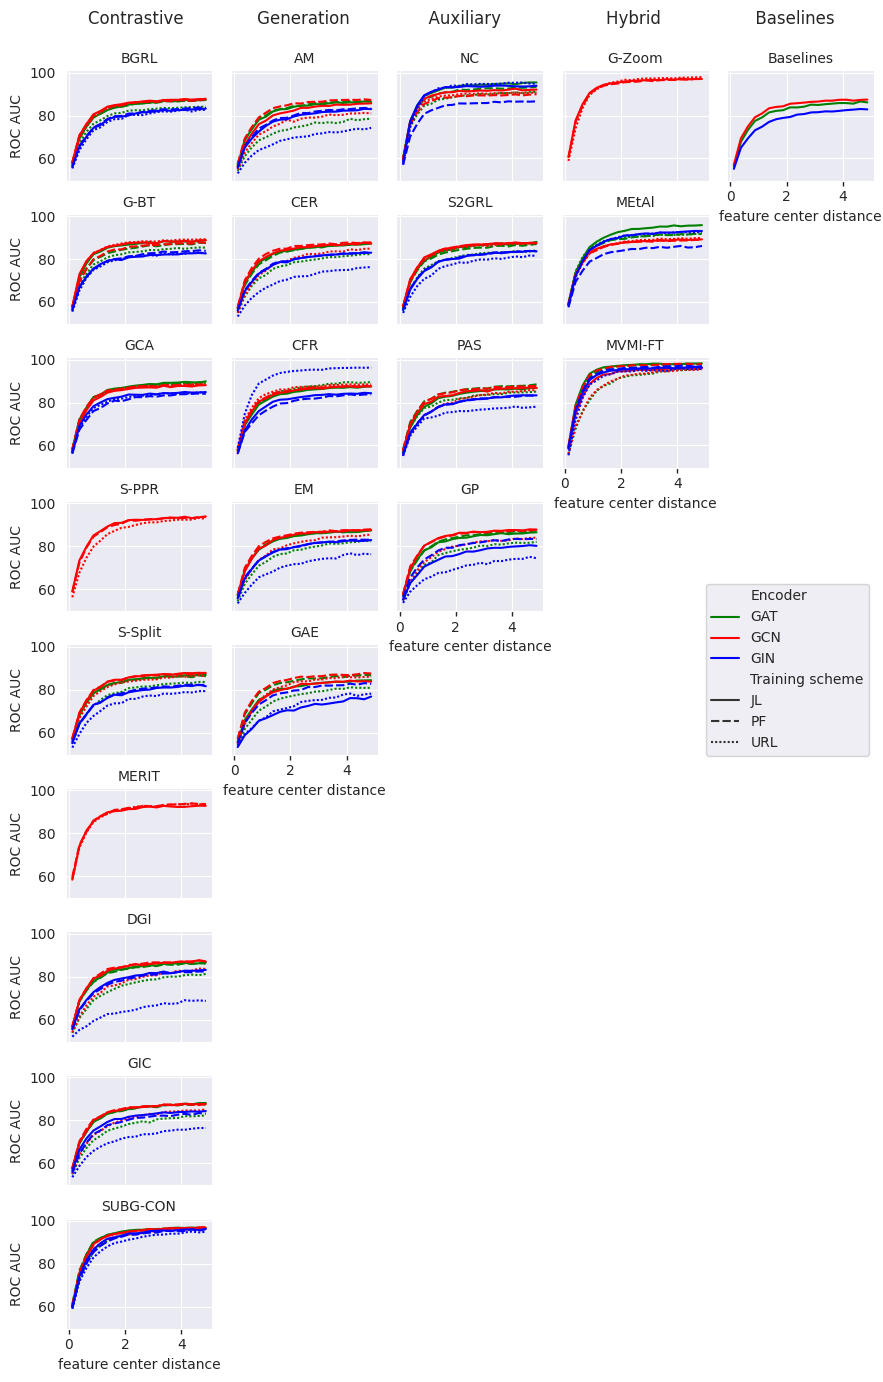

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


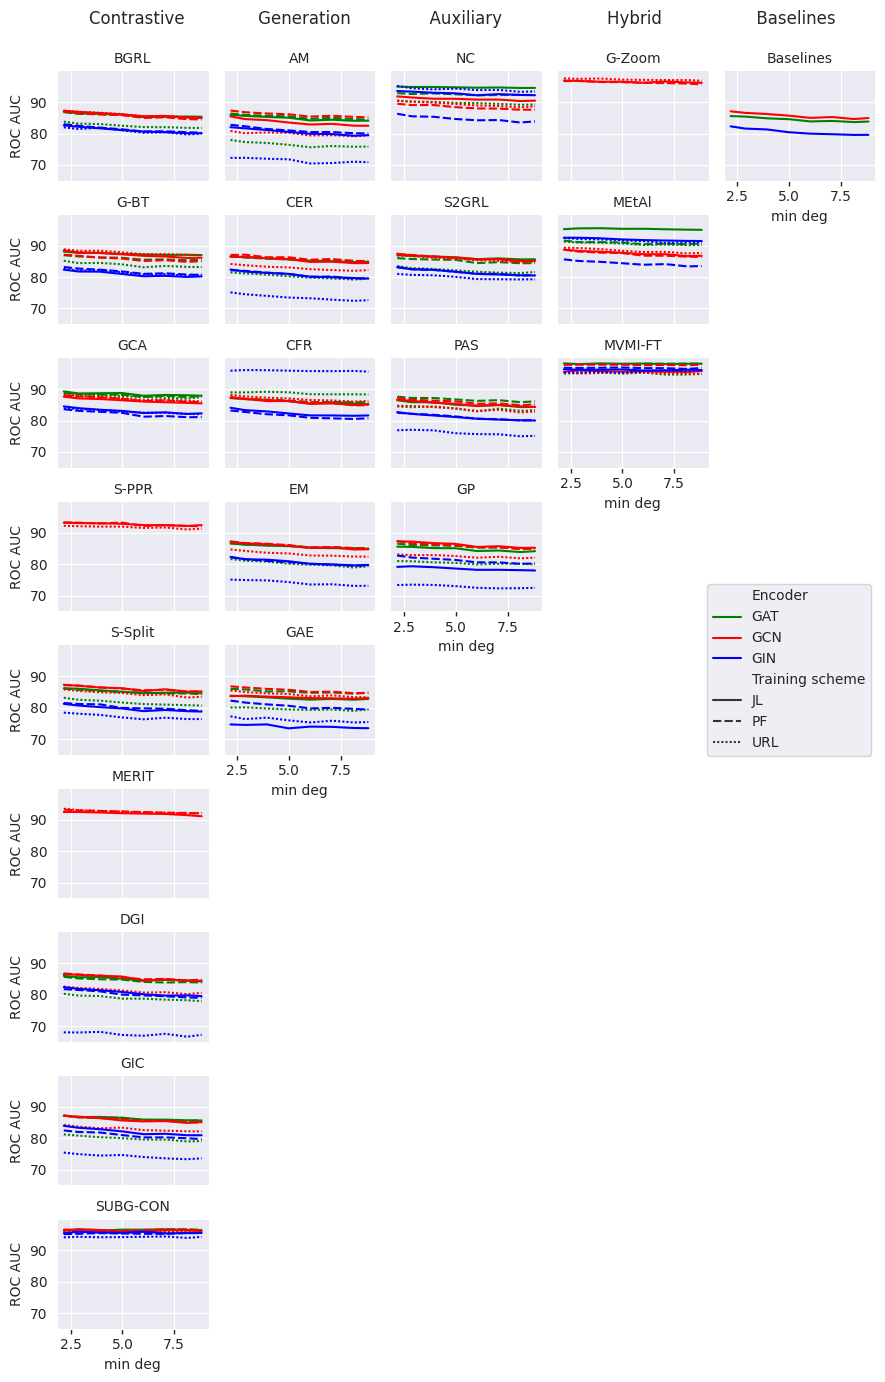

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


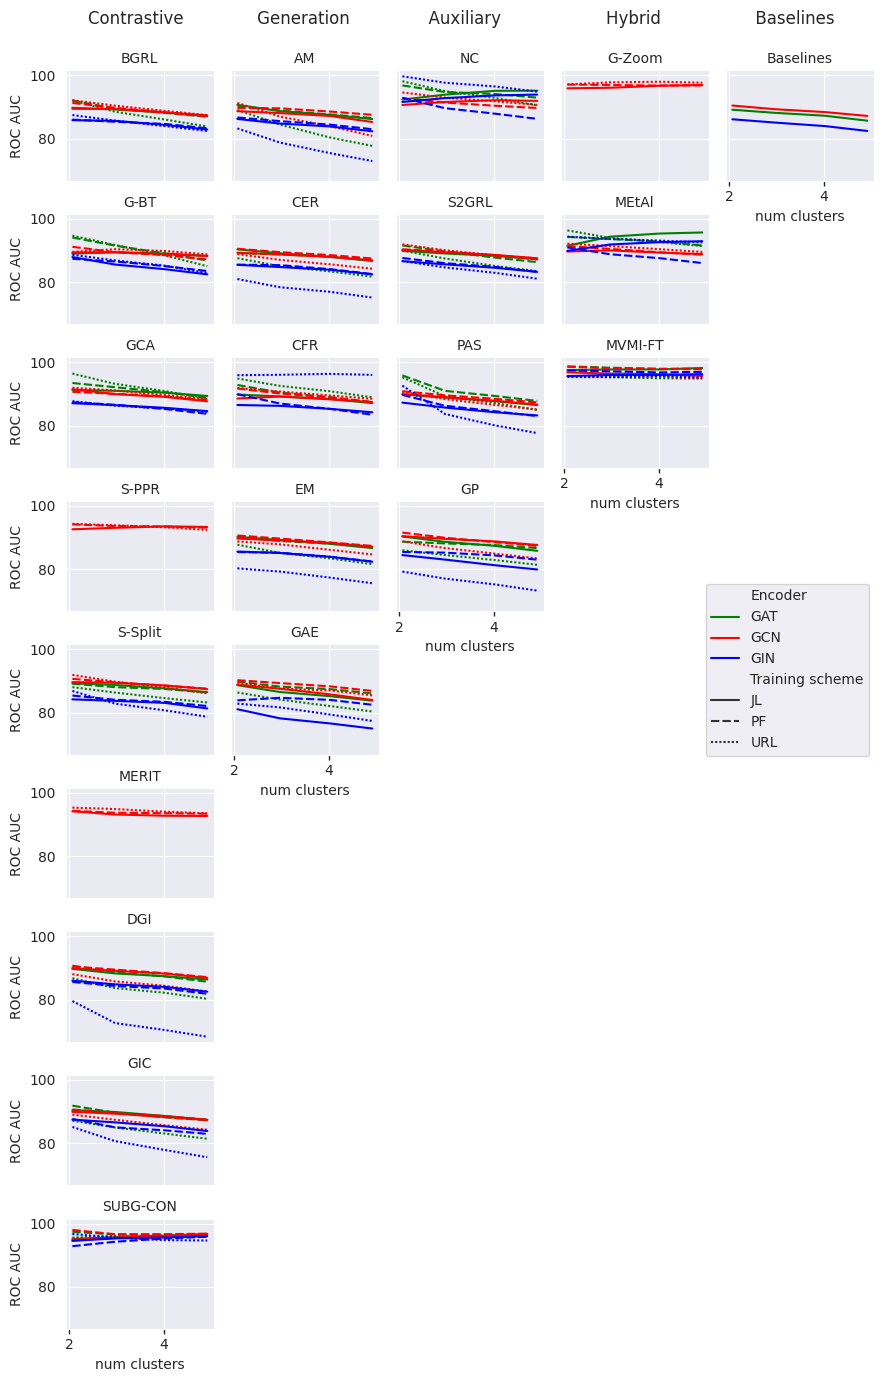

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


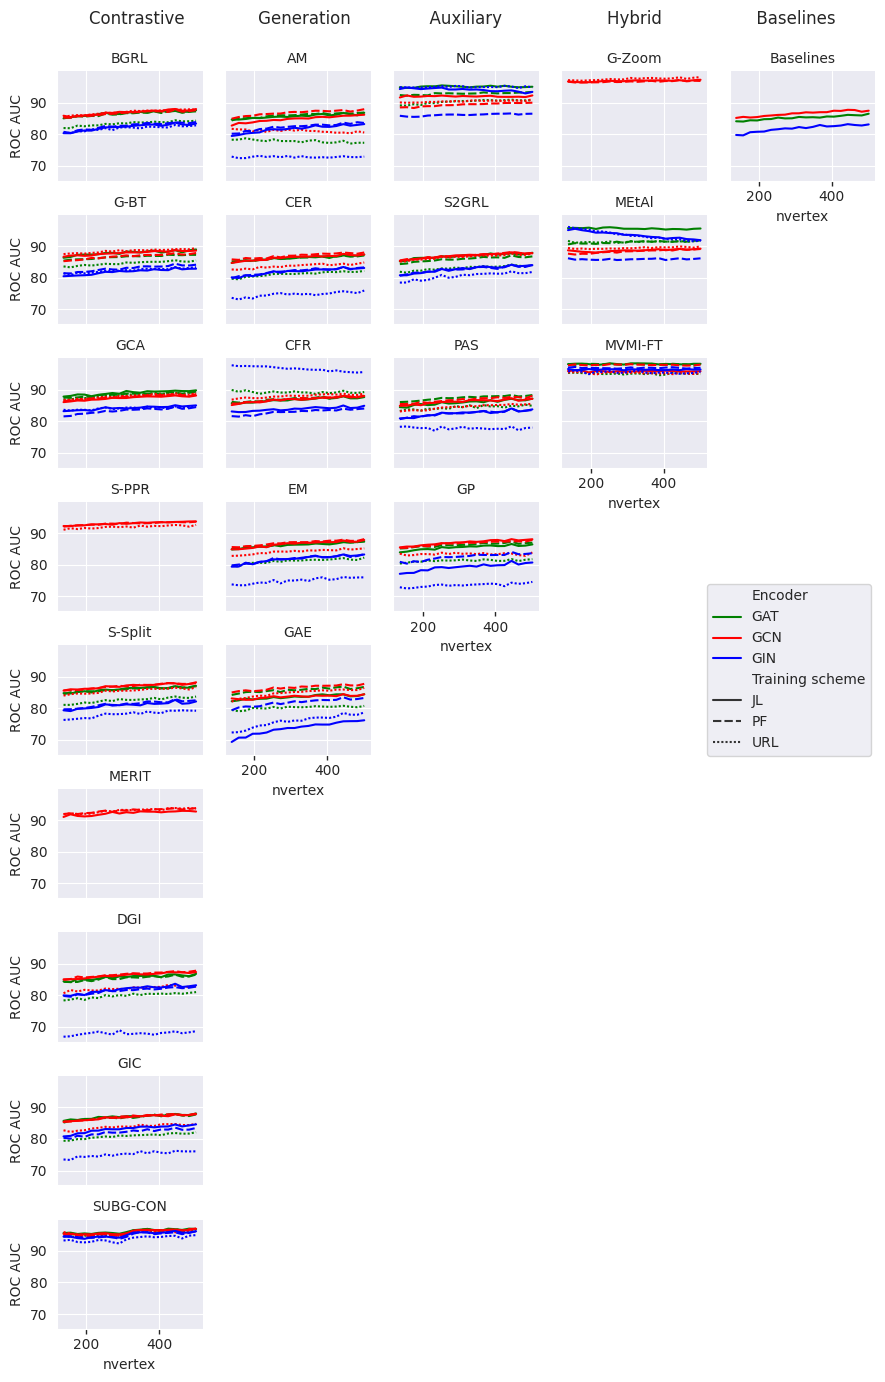

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


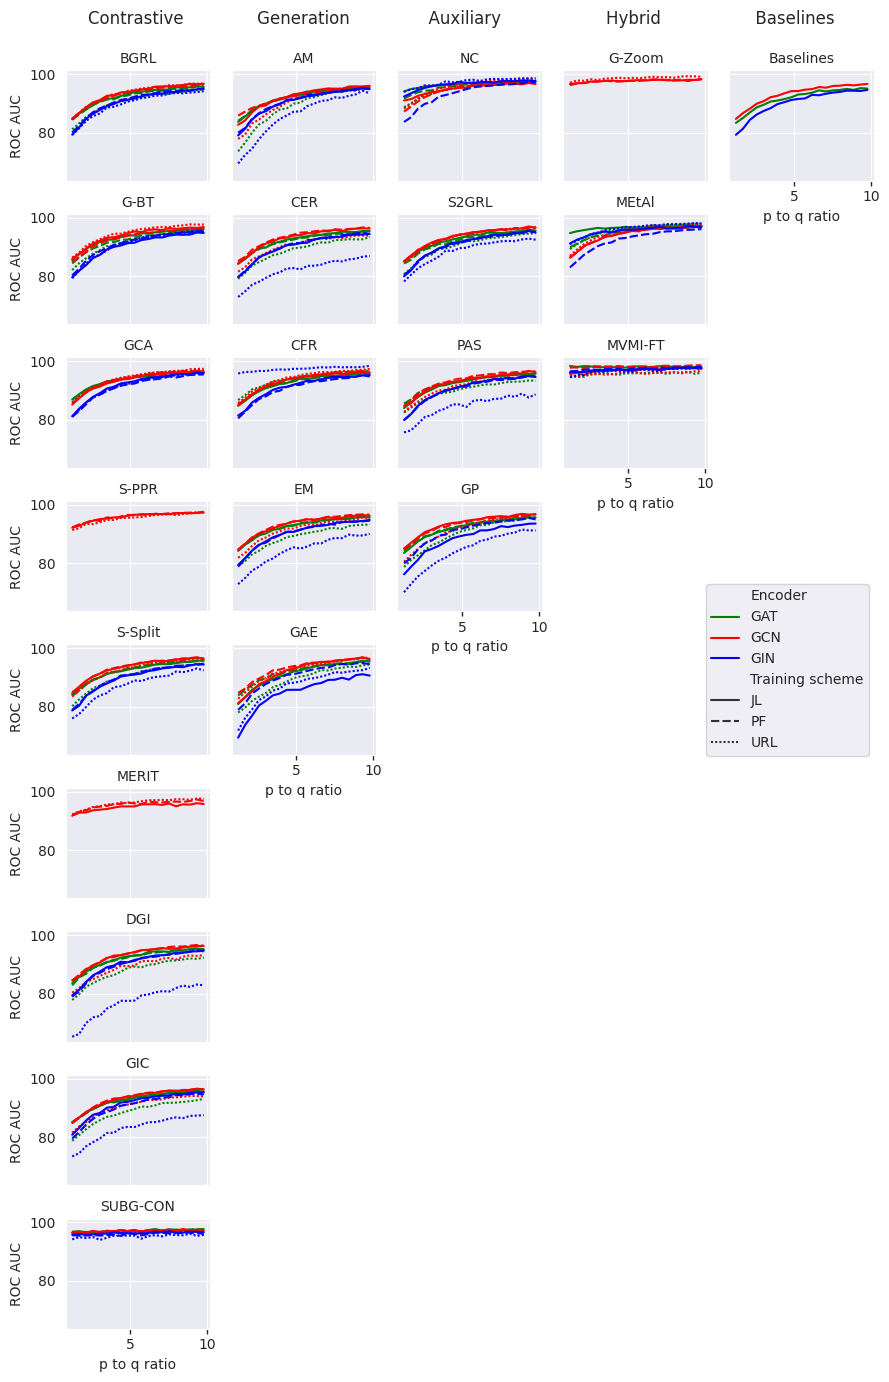

/tmp/ipykernel_6127/2132539058.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


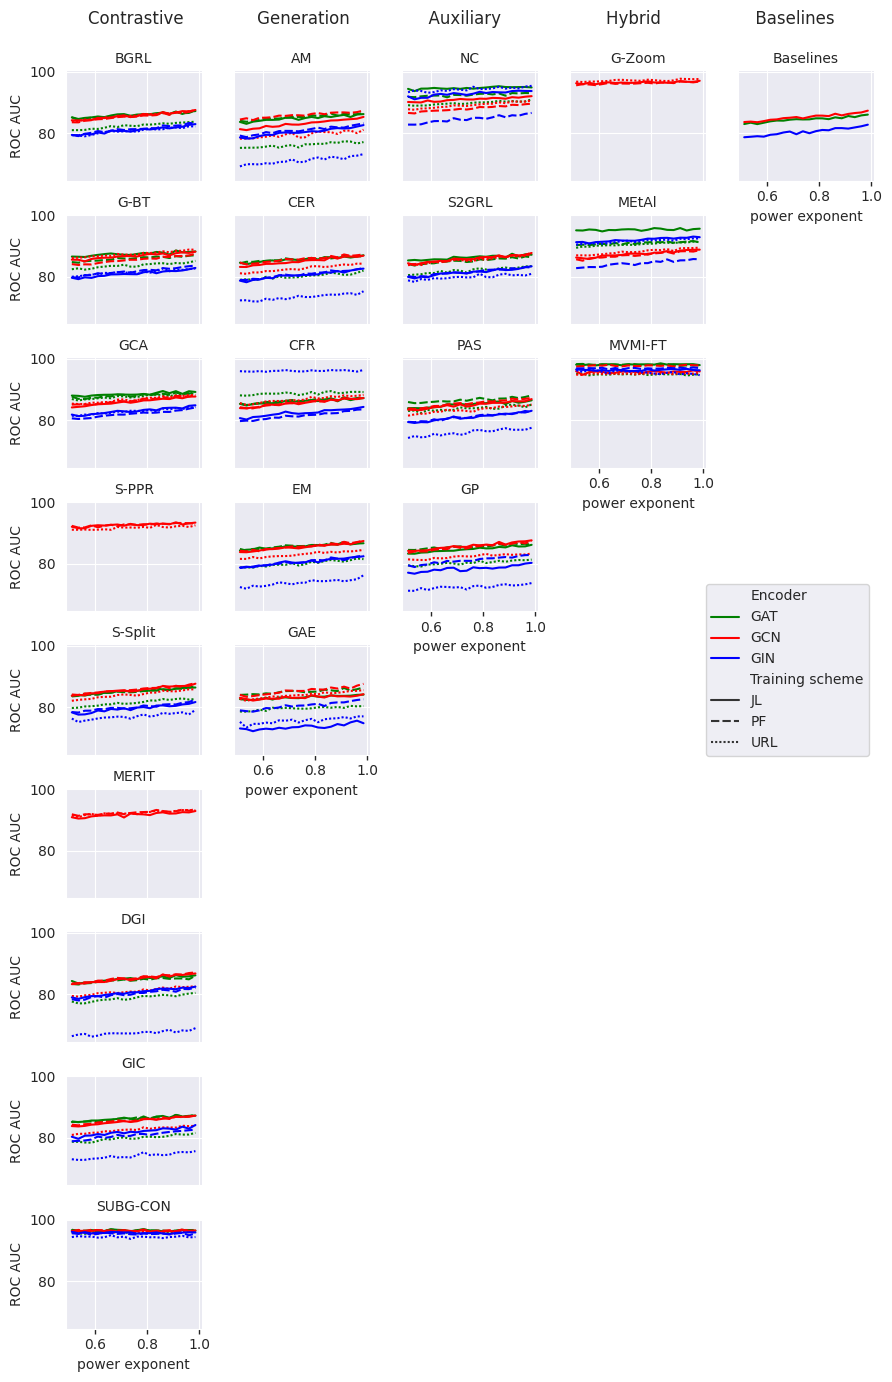

In [4]:
# Construct plotting dataframe
df_baseline['SSL_model'] = "Baselines"
df_baseline['Training_scheme'] = "JL"
df_baseline = df_baseline.rename(columns={"Baseline_model": "Encoder"})
df_plot = pd.concat([df_ssl, df_baseline], ignore_index=True)
df_plot.rename(columns={TEST_METRIC: "ROC AUC"}, inplace=True)
df_plot.rename(columns=lambda x: x.replace('_', ' '), inplace=True)
df_plot['SSL model'] = df_plot['SSL model'].apply(lambda x: x if x == "Baselines" else model_abbreviations[x])
df_plot = df_plot.sort_values(by=['Encoder', 'Training scheme'])

# Styling
markers={'PF':'o', 'URL':'s', 'JL':'X'}
sns.set_style("darkgrid")

# Function to correct the titles made by seaborn
def set_custom_titles(**kwargs):
    title = kwargs['facet'].name.split("=")[-1]
    plt.gca().set_title(title)


# Hack to display the grid of plots such that each column is an SSL category
order = []
rows = len(CONTRAST_ALL)
for (c,g,a,h,b) in zip_longest(CONTRAST_ALL, GENERATION_ALL, AUXILIARY_ALL,  HYBRID_ALL, ["Baselines"], fillvalue="empty"):
    order.append(model_abbreviations.get(c)); order.append(model_abbreviations.get(g)) 
    order.append(model_abbreviations.get(a)); order.append(model_abbreviations.get(h))
    order.append(b)

# Make a plot for each graph parameter
for param, param_group in df_plot.groupby(df_plot['marginal param'].apply(tuple)):
    if len(param) > 1 or param[0] == "min_degree": # Discard two-param marginalization + incorrect configuration for min degree
        continue
    param = param[0].replace("_", " ")
    param_group[param] = pd.cut(param_group[param], bins=20, duplicates='drop').apply(lambda x: x.mid)
    g = sns.relplot(
        data=param_group, x=param, y="ROC AUC",
        col="SSL model", hue="Encoder", style="Training scheme", col_wrap=5, height=1.5, aspect=1.2,
        kind="line", markers=None, dashes=True, errorbar=None, col_order=order, palette=ENCODER_COLORS, 
    )
    g.set_titles("{col_name}") 

    # Correct the xlabel positions based on the empty plots
    xlabel = g.axes[40].get_xlabel()
    xticklabels = g.axes[40].get_xticklabels()
    for i in [4, 13, 17, 21, 40]:
        g.axes[i].set_xlabel(xlabel, visible=True)
        g.axes[i].set_xticklabels(xticklabels, visible=True)
        g.axes[i].tick_params(axis='x', which='both', bottom=True, top=False, width=0)
        g.axes[i].get_xaxis().set_ticks_position('bottom')
        g.axes[i].get_xaxis().set_tick_params(which='both', width=1)

    # Set empty plots invisible
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()
            ax.set_title("")

    sns.move_legend(g, "upper left", bbox_to_anchor=(.69, .6), frameon=True)
    plt.suptitle("Contrastive              Generation               Auxiliary                    Hybrid                  Baselines", 
                 y=1.02, x = 0.1, horizontalalignment='left')
    plt.show()

## Main plots with embeddings

In [5]:
def get_embeddings_df(res_dir, param, perplexity=30):
    df_temp = read_processed_shards(join(RESULTS_ROOT, res_dir, 'processed'))
    df_embeddings = unpivot_ssl_model(df=df_temp, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, 
                                                 training_schemes=TRAINING_SCHEMES,  include_graph_params=True, include_embeddings=True)

    frames  = []
    for index, row in df_embeddings.iterrows():
        df_temp = pd.DataFrame()
        tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, learning_rate='auto', init='pca')
        tsne_results = tsne.fit_transform(np.array(row['embeddings']))
        df_temp['x1'] = tsne_results[:,0]
        df_temp['x2'] = tsne_results[:,1]
        df_temp['SSL model'] = model_abbreviations[row['SSL_model']]
        df_temp['classes'] = np.array(row['classes'])
        df_temp['Encoder'] = row['Encoder']
        df_temp['Training scheme'] = row['Training_scheme']
        df_temp[param] = row[param.replace(" ","_")]
        df_temp['ROC AUC'] = row['test_rocauc_ovr']
        frames.append(df_temp)

    return pd.concat(frames, ignore_index=True)

In [52]:
def plot_aggregated_param_performance(df_marg, param):
    with sns.axes_style("darkgrid"):
        df_temp = df_marg.copy()
        df_temp[param] = pd.cut(df_temp[param], bins=20, duplicates='drop').apply(lambda x: x.mid)
        df_temp['type'] = df_temp["SSL model"] == "Baselines"

        g = sns.relplot(data=df_temp, x=param, y='ROC AUC', hue='Encoder', kind='line', errorbar=None,
                    style='Training scheme', palette=ENCODER_COLORS, col='type', height=3, col_wrap=1, aspect=1.5)

        sns.move_legend(g, "upper left", bbox_to_anchor=(0.77, 0.955), frameon=True)
        g.axes[0].set_title("SSL methods")
        g.axes[1].set_title("Baselines")
        plt.suptitle("Average ROC AUC aggregated for all models", y=1.05)

In [76]:
def plot_marginalization_with_embeddings(df_marg, df_embed, param, method, filter_e_ts, remove_embed_values, 
                                         draw_legend=False, ylim=(65,100), yticks=[75, 80, 85, 90, 95, 100], ax=None):
    sns.set_style("white")
    df_marg_plot = df_marg.copy()
    df_marg_plot = df_marg_plot.sort_values(by=['Encoder', 'Training scheme'])
    df_marg_plot = df_marg_plot[df_marg_plot['SSL model'] == method] 
    df_embed_plot = df_embed.copy()
    df_embed_plot = df_embed_plot.sort_values(by=['Encoder', 'Training scheme'])
    df_embed_plot = df_embed_plot[df_embed_plot['SSL model'] == method]

    df_marg_plot[param] = pd.cut(df_marg_plot[param], bins=20, duplicates='drop').apply(lambda x: x.mid)
    with sns.axes_style("darkgrid"):
        ax = sns.lineplot(data=df_marg_plot, x=param, y='ROC AUC', hue=df_marg_plot['Encoder'], style='Training scheme',
                    markers=None, dashes=True, errorbar=None, palette=ENCODER_COLORS, legend=draw_legend, ax=ax)
        ax.set_ylim(ylim[0], ylim[1])
    for i, (e_ts_name, e_ts_group) in enumerate(df_embed_plot.groupby(['Encoder', 'Training scheme'])):
        if e_ts_name not in filter_e_ts:
            continue
        for j, (param_value, param_group) in enumerate(e_ts_group.groupby(param)):
            if j in remove_embed_values:
                continue
            lines = ax.get_lines()
            closest_index = (np.abs(lines[i].get_xdata() - param_value)).argmin()
            x_val = lines[i].get_xdata()[closest_index]
            y_val = lines[i].get_ydata()[closest_index]

            min_x, max_x = ax.get_xlim(); min_y, max_y = ax.get_ylim()
            width = (max_x - min_x)/(3*1.5)
            height = ((max_y - min_y)/3) / 1.4
            if max_x - x_val > x_val - min_x:
                offset = min_x - width - (max_x-min_x)/7
                arrow_start = min_x - (max_x-min_x)/7
                offset_y = filter_e_ts[e_ts_name][0]
                multiplier = -1
            else: 
                offset = max_x
                arrow_start = max_x
                offset_y = filter_e_ts[e_ts_name][1]
                multiplier = 1
        
            #max_y - 0.5*height - offset_y * height
            
            ax2_y = max_y-1.2*height-offset_y*(1.4*height)
            ax2 = ax.inset_axes([offset, ax2_y, width, height],
                            transform=ax.transData)
            ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_xlabel(""); ax2.set_ylabel("")


            sns.scatterplot(data=param_group, x='x1', y='x2', hue='classes', legend=False, s=5,
                palette = sns.color_palette("hls", len(param_group['classes'].unique())), ax=ax2)
            
            sc = silhouette_score(param_group[['x1', 'x2']], param_group['classes'])
            print(sc, param_group['ROC AUC'].unique())
            ax2.text(0.95, 0.8, "{:.2f}".format(sc), transform=ax2.transAxes, ha="right", va="bottom")
            
            ax.scatter(x=[x_val, arrow_start, arrow_start, arrow_start+multiplier*width],y=[y_val, ax2_y+height,  ax2_y, ax2_y+height], color='darkblue', s=5, clip_on=False, zorder=100, alpha=0.3)
            triangle1 = Polygon(xy=[(arrow_start, ax2_y+height), (arrow_start, ax2_y), (x_val, y_val)], zorder=5, fill=False,
                               facecolor='lightblue', edgecolor='black', alpha=0.3, linewidth=1.5, clip_on=False)
            ax.add_patch(triangle1)
            triangle2 = Polygon(xy=[(arrow_start+multiplier*width, ax2_y+height), (arrow_start, ax2_y+height), (x_val, y_val)], zorder=5, fill=False,
                               facecolor='lightblue', edgecolor='black', alpha=0.3, linewidth=1.5, clip_on=False)
            ax.add_patch(triangle2)
            # triangle3 = Polygon(xy=[(arrow_start+multiplier*width, ax2_y+height), (arrow_start, ax2_y), (x_val, y_val)], zorder=5, fill=False,
            #                    facecolor='lightblue', edgecolor='black', alpha=0.3, linewidth=1.5, clip_on=False)
            # ax.add_patch(triangle3)
            ax.set_yticks(yticks)
            ax.set_xlim(min_x, max_x)
    if draw_legend:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1.25, 1.02))
    ax.set_title(method)


In [8]:
best_method_performance = df_plot.loc[df_plot.groupby(["Graph ID", "SSL model"])["ROC AUC"].idxmax()]


In [9]:
def plot_ranks(interesting_methods, param):
    df_temp = best_method_performance.copy()
    df_temp[param] = pd.cut(df_temp[param], bins=20, duplicates='drop').apply(lambda x: x.mid)
    df_grouped = df_temp.groupby([param, 'SSL model']).mean().reset_index()
    df_grouped['rank'] = df_grouped.groupby(param)['ROC AUC'].rank(method='dense', ascending=False)

    fig, ax = plt.subplots(figsize=(5,8))

    palette = {}
    for m in model_abbreviations.values():
        if m not in interesting_methods:
            palette[m] = (0.9,0.9,0.9) # grey

    for c, m in zip(sns.color_palette("hls", len(interesting_methods)), interesting_methods):
        palette[m] = c

    sns.lineplot(data = df_grouped, x=param, y="rank", hue="SSL model", errorbar=None, legend=False, marker='o',
                    palette=palette, clip_on=True, ax=ax)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.02))
    ax.set_yticks([])
    ax.set_ylabel("")

    min_param = df_grouped[param].min(); max_param = df_grouped[param].max()
    ax.set_xlim(min_param,max_param)
    ax.invert_yaxis()
    ranks_lowest_param = df_grouped[df_grouped[param] == min_param].sort_values(by="rank", ascending=True, ignore_index=True)
    ranks_highest_param = df_grouped[df_grouped[param] == max_param].sort_values(by="rank", ascending=True, ignore_index=True)

    for index, row in ranks_lowest_param.iterrows():
        ax.text(min_param-(max_param-min_param)/100, index+1, row['SSL model'], horizontalalignment='right', verticalalignment='center')

    for index, row in ranks_highest_param.iterrows():
        ax.text(max_param+(max_param-min_param)/100, index+1, row['SSL model'], horizontalalignment='left', verticalalignment='center')
    plt.title(f"Ranked methods per {param}")
    plt.show()

#### Avg degree

In [10]:
df_embed_avg_degree = get_embeddings_df('embeddings_avg_degree', param ="avg degree", perplexity=50)

1.ndjson
2.ndjson
concatenating


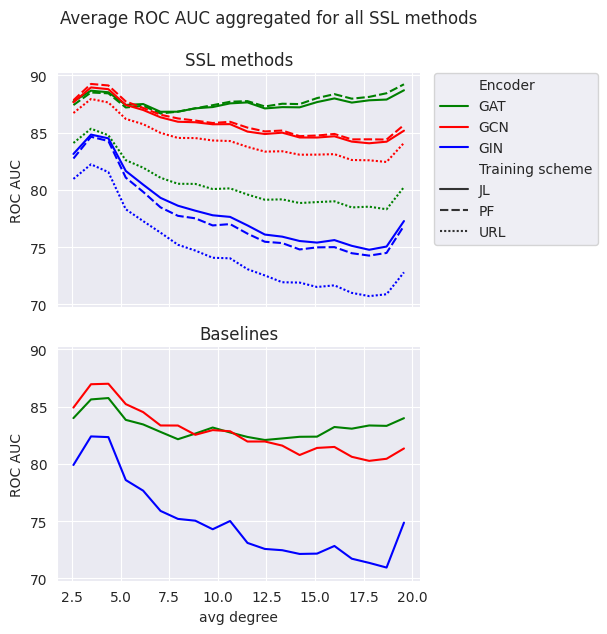

In [53]:
plot_aggregated_param_performance(df_marg = df_plot, param="avg degree")

0.11271229 [80.72470835]
0.34937412 [89.4682614]
0.286829 [86.17477363]
0.06506763 [75.53544146]
0.0740846 [75.6242481]
-0.09592835 [60.62288884]


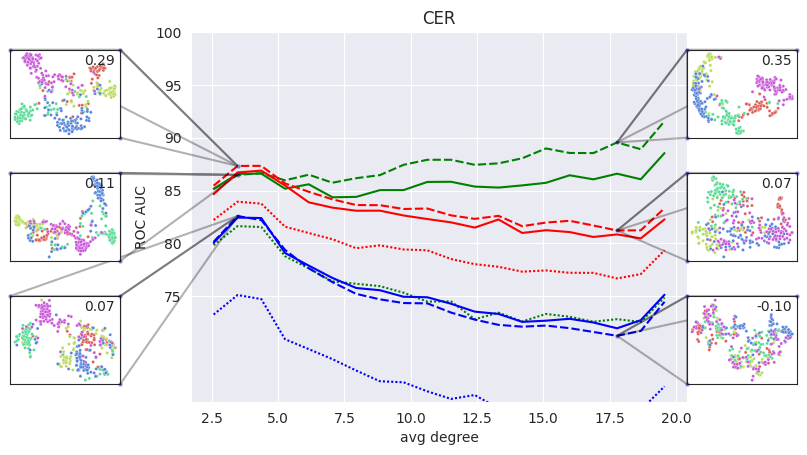

0.28246173 [83.97174573]
0.5256236 [94.26151685]
0.74105644 [97.21930607]
0.07715879 [82.14975949]


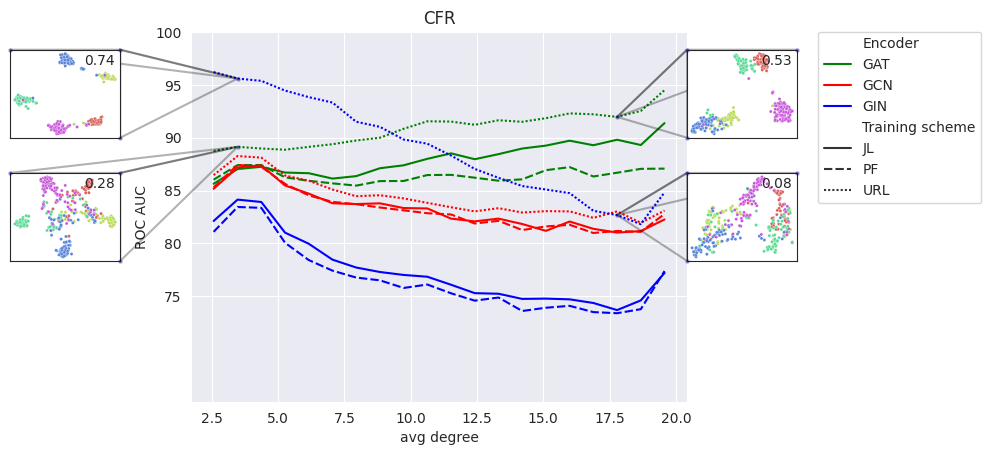

0.5722348 [95.20282633]
0.67436993 [98.32735325]


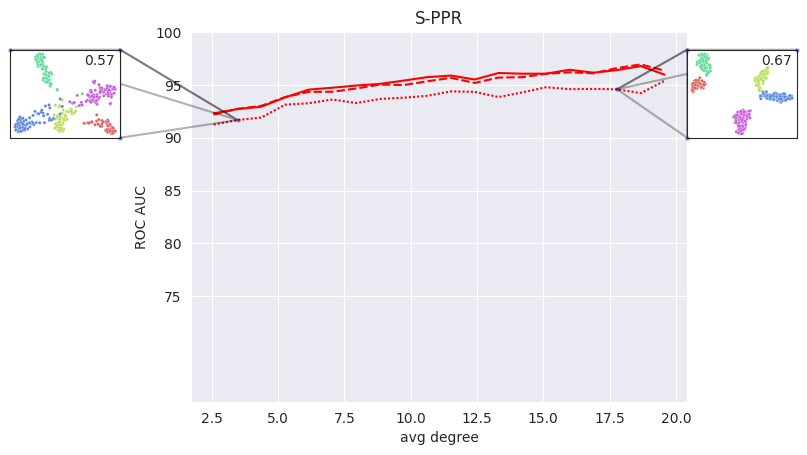

0.85792255 [99.32550888]
0.9337021 [100.]


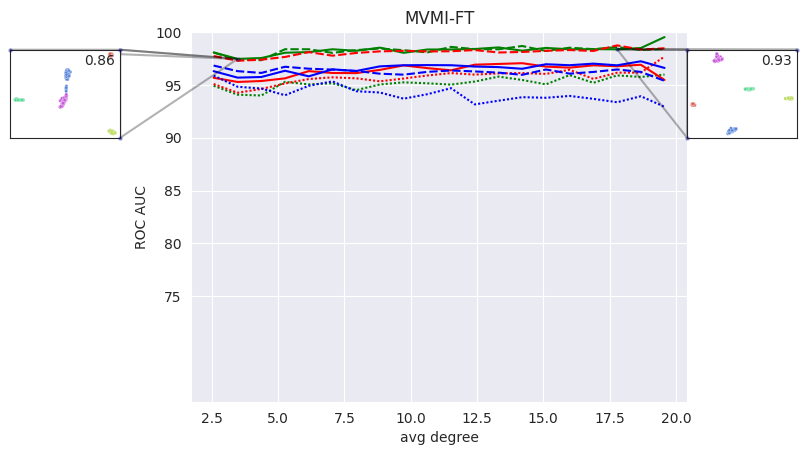

0.725246 [98.07007917]
0.21878959 [82.19783909]
0.61263347 [93.44911331]
0.066960886 [76.25778596]


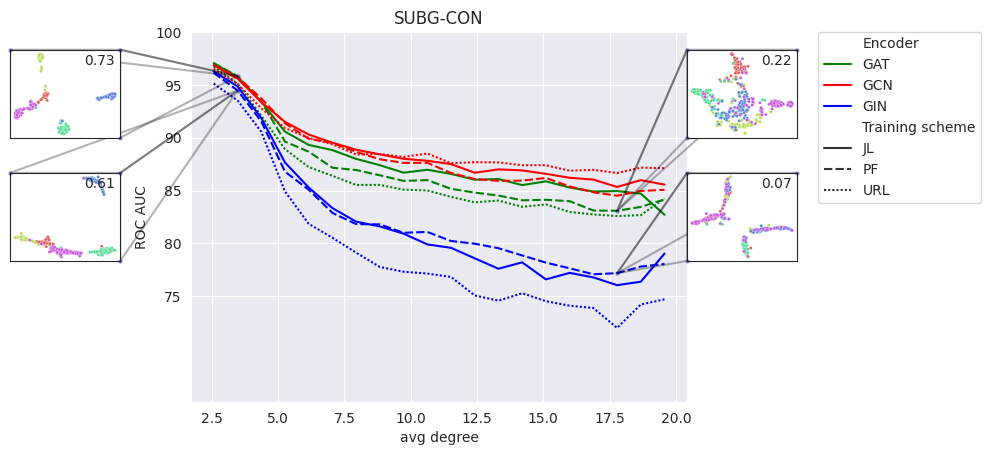

In [83]:
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_avg_degree, method="CER", param = "avg degree", 
                                          filter_e_ts={("GCN", "PF"):(0,1),("GAT", "PF"):(1,0), ("GIN", "PF"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=False)
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_avg_degree, method="CFR", param = "avg degree", 
                                          filter_e_ts={("GIN", "URL"):(0,1),("GAT", "URL"):(1,0)}, 
                                          remove_embed_values=[], draw_legend=True)
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_avg_degree, method="S-PPR", param = "avg degree", 
                                          filter_e_ts={("GCN", "URL"):(0,0)}, 
                                          remove_embed_values=[], draw_legend=False)
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_avg_degree, method="MVMI-FT", param = "avg degree", 
                                          filter_e_ts={("GAT", "JL"):(0,0)}, 
                                          remove_embed_values=[], draw_legend=False)
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_avg_degree, method="SUBG-CON", param = "avg degree", 
                                          filter_e_ts={("GAT", "PF"):(0,0), ("GIN", "PF"):(1,1)}, 
                                          remove_embed_values=[], draw_legend=True)
plt.show()

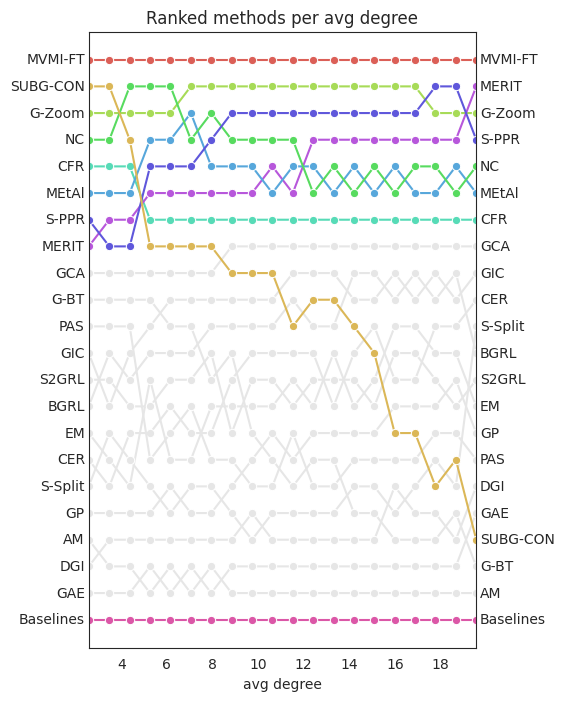

In [13]:
plot_ranks(interesting_methods = ['MVMI-FT', 'SUBG-CON', 'G-Zoom', 'NC', 'CFR', 'MEtAl', 'S-PPR', 'MERIT', 'Baselines'], 
           param ='avg degree')

#### Cluster size slope

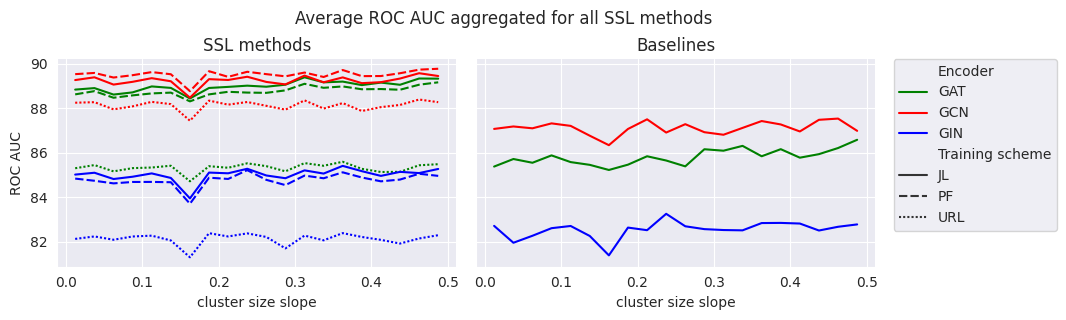

In [14]:
plot_aggregated_param_performance(df_marg = df_plot, param="cluster size slope")

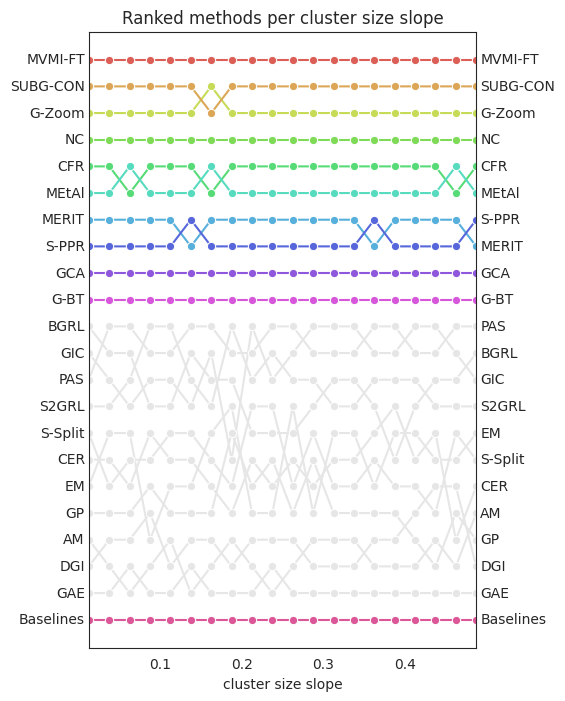

In [15]:
plot_ranks(interesting_methods = ["MVMI-FT", "SUBG-CON", "G-Zoom", "NC", "CFR", "MEtAl", "MERIT", "S-PPR", "GCA", "G-BT", "Baselines"], 
           param ='cluster size slope')

#### Feature center distance

In [16]:
df_embed_feature_center_distance = get_embeddings_df('embeddings_feature_center_distance', param="feature center distance", perplexity=50)

1.ndjson
2.ndjson
concatenating


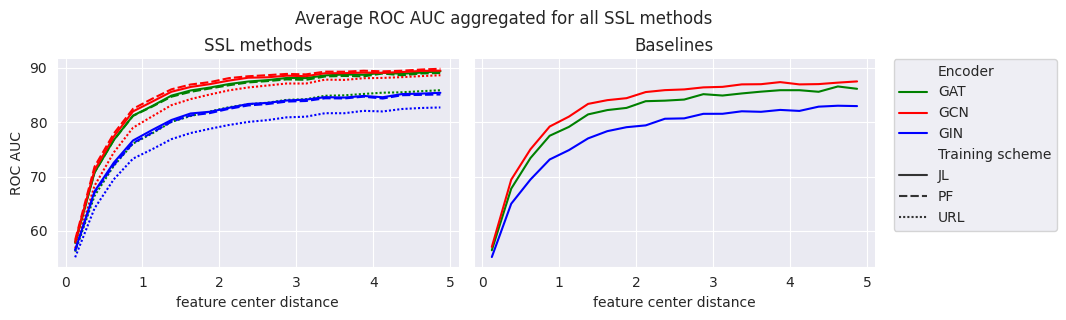

In [17]:
plot_aggregated_param_performance(df_marg = df_plot, param="feature center distance")

0.038079843 [74.46662186]
0.23510589 [84.14846286]
0.0049439375 [74.36478565]
0.2939346 [87.8391491]
-0.049221676 [67.17410898]
0.19036564 [82.85472425]


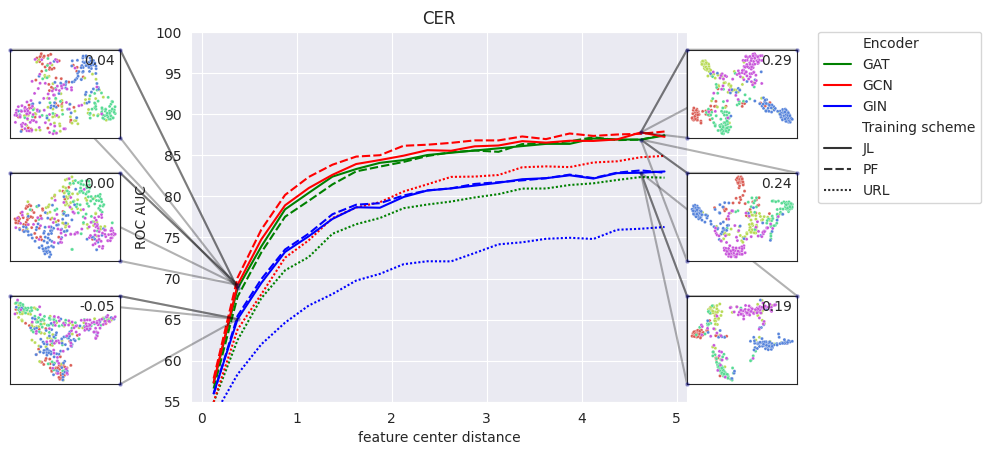

0.09391333 [76.3193244]
0.30778706 [86.0993067]
0.17534882 [76.60944784]
0.7068398 [96.48534013]


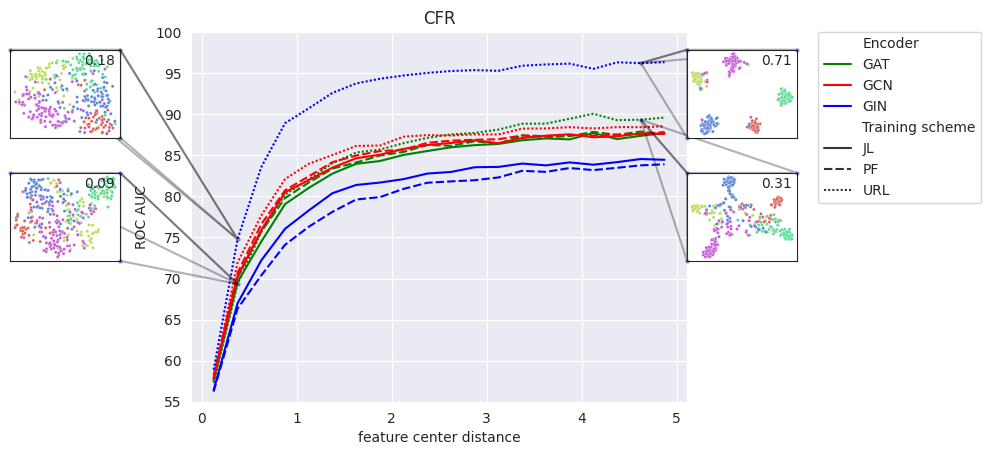

0.15180929 [83.13159268]
0.66703063 [96.46952374]


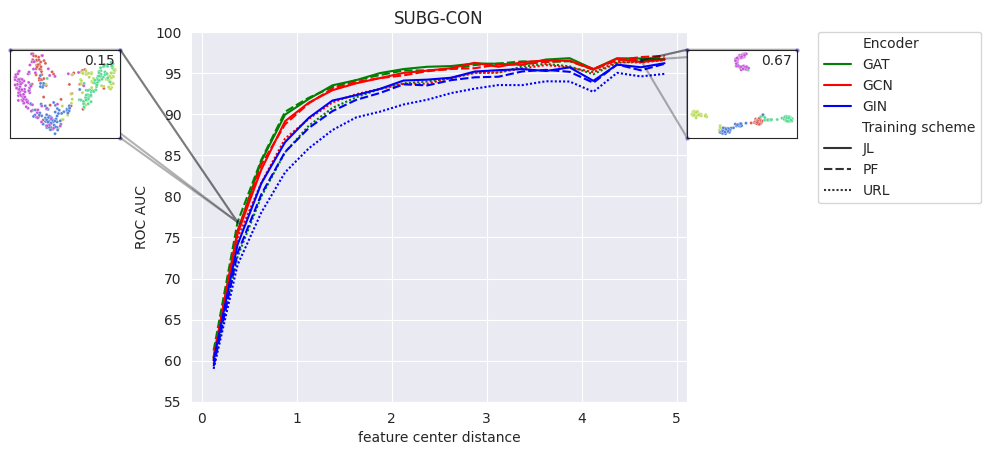

In [18]:
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_feature_center_distance, method="CER", param = "feature center distance", 
                                          filter_e_ts={("GCN", "JL"):(1,0),("GAT", "JL"):(0,1), ("GIN", "JL"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(55, 100), yticks=[55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_feature_center_distance, method="CFR", param = "feature center distance", 
                                          filter_e_ts={("GIN", "URL"):(0,0),("GAT", "URL"):(1,1)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(55, 100), yticks=[55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_feature_center_distance, method="SUBG-CON", param = "feature center distance", 
                                          filter_e_ts={("GAT", "PF"):(0,0)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(55, 100), yticks=[55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.show()

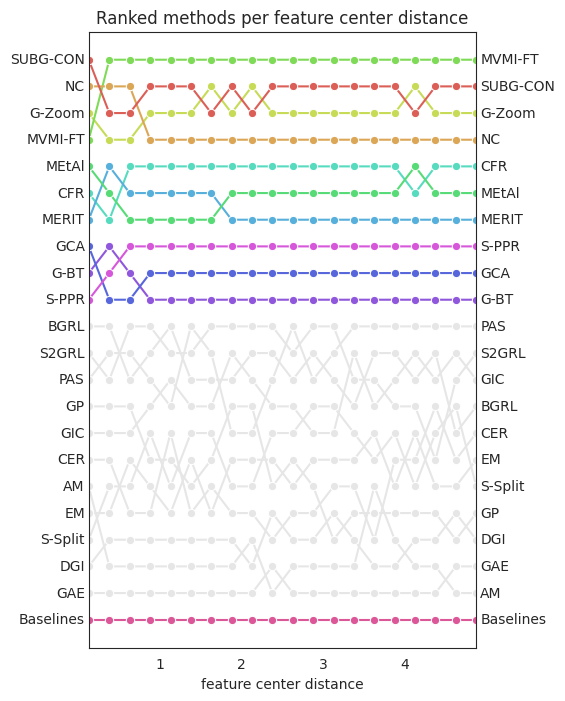

In [19]:
plot_ranks(interesting_methods = ["SUBG-CON","NC","G-Zoom","MVMI-FT","MEtAl","CFR", "MERIT", "GCA","G-BT","S-PPR","Baselines"], 
           param ='feature center distance')

#### min deg

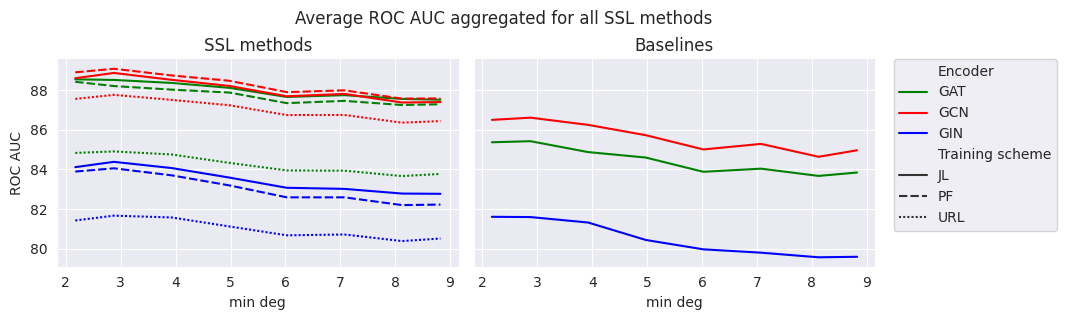

In [20]:
plot_aggregated_param_performance(df_marg = df_plot, param="min deg")

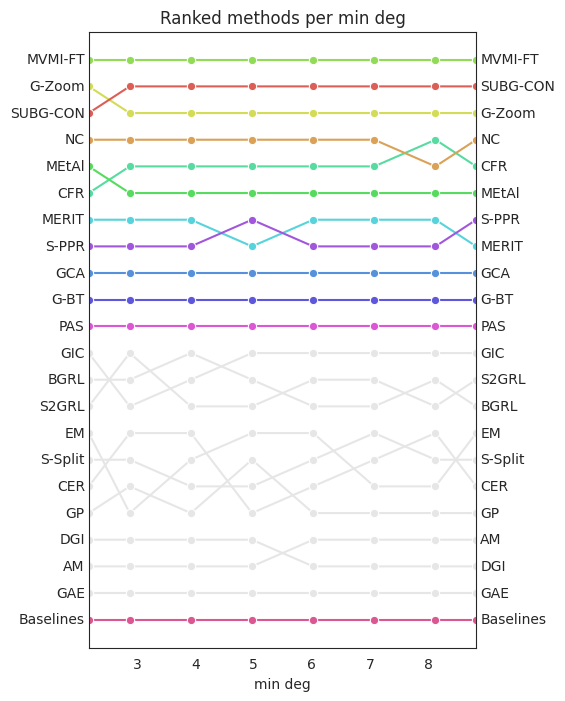

In [21]:
plot_ranks(interesting_methods = ["SUBG-CON","NC","G-Zoom","MVMI-FT","MEtAl","CFR","MERIT","GCA","G-BT","S-PPR", "PAS","Baselines"], 
           param ='min deg')

#### Num clusters

In [23]:
df_embed_num_clusters = get_embeddings_df('embeddings_num_clusters', param="num clusters", perplexity=50)

1.ndjson
2.ndjson
concatenating


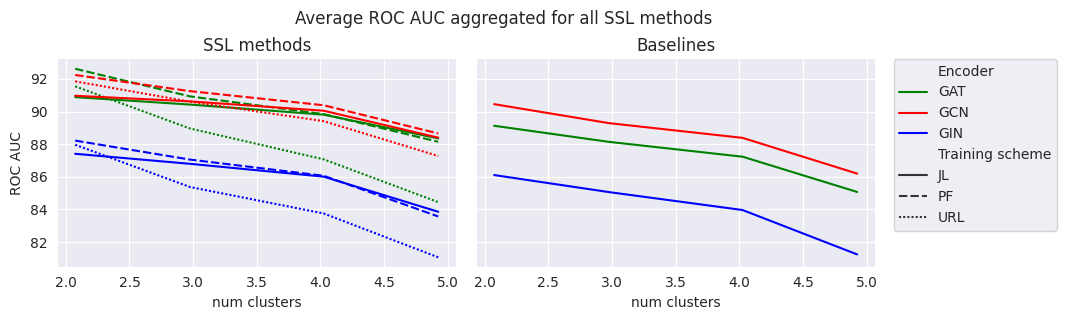

In [24]:
plot_aggregated_param_performance(df_marg = df_plot, param="num clusters")

0.63340765 [89.39393939]
0.25078276 [82.1162539]
0.6370365 [95.52099947]
0.2660012 [86.27226472]
0.534507 [83.83838384]
0.047709215 [79.45046886]


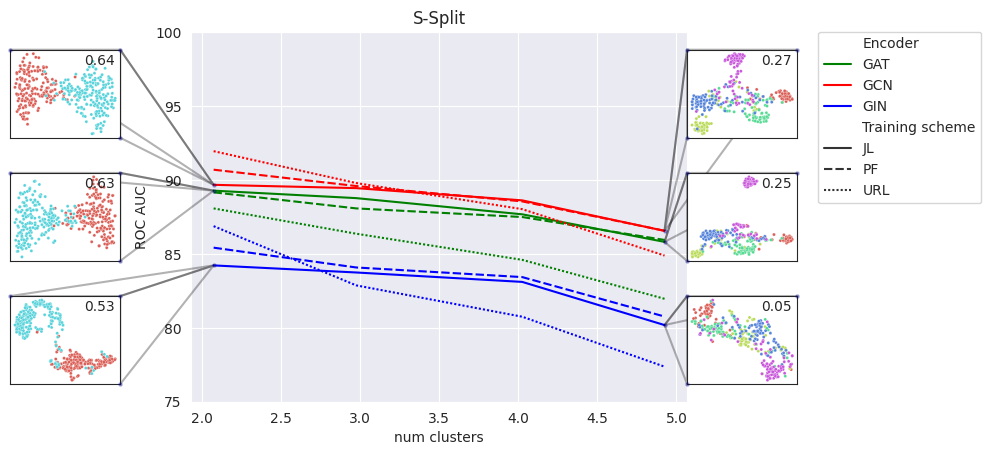

0.7117703 [99.74747475]
0.21543808 [84.78619742]


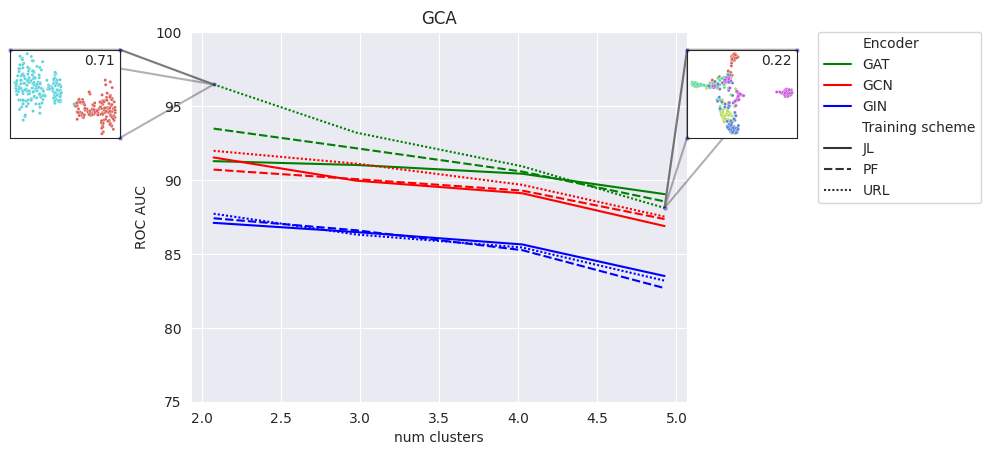

0.8395454 [99.74747475]
0.7533574 [98.61344348]


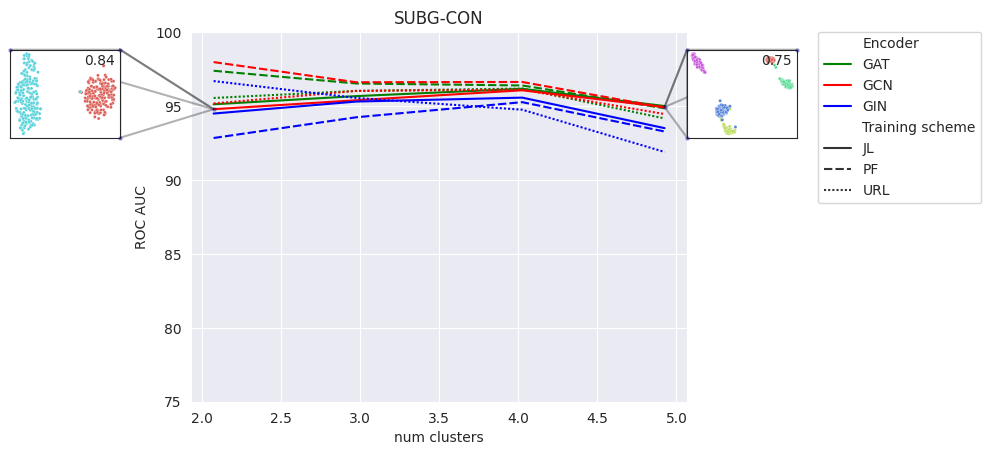

0.30246753 [85.06113769]
0.19641428 [82.12784442]
0.69577247 [96.67729931]
0.5781149 [91.5750547]


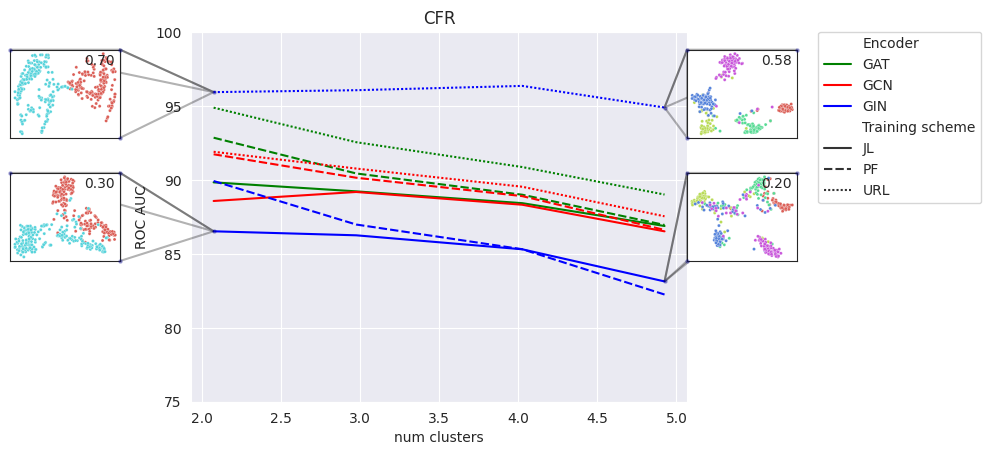

In [31]:
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_num_clusters, method="S-Split", param = "num clusters", 
                                          filter_e_ts={("GCN", "JL"):(0,0),("GAT", "JL"):(1,1), ("GIN", "JL"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(75, 100), yticks=[75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_num_clusters, method="GCA", param = "num clusters", 
                                          filter_e_ts={("GAT", "URL"):(0,0)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(75, 100), yticks=[75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_num_clusters, method="SUBG-CON", param = "num clusters", 
                                          filter_e_ts={("GCN", "JL"):(0,0)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(75, 100), yticks=[75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_embed_num_clusters, method="CFR", param = "num clusters", 
                                          filter_e_ts={("GIN", "URL"):(0,0),("GIN", "JL"):(1,1)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(75, 100), yticks=[75, 80, 85, 90, 95, 100])
plt.show()

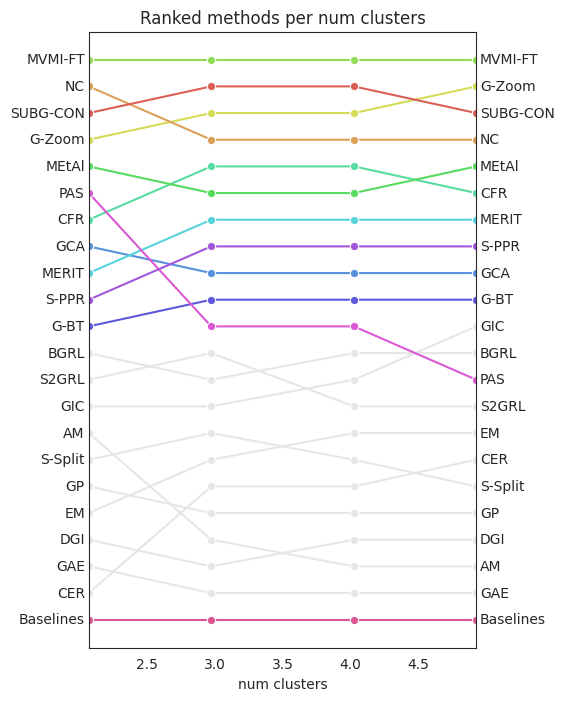

In [ ]:
plot_ranks(interesting_methods = ["SUBG-CON","NC","G-Zoom","MVMI-FT","MEtAl","CFR","MERIT","GCA","G-BT","S-PPR", "PAS", "Baselines"], 
           param ='num clusters')

#### nvertex

In [54]:
df_nvertex = get_embeddings_df('embeddings_nvertex', param="nvertex", perplexity=50)

1.ndjson
2.ndjson
concatenating


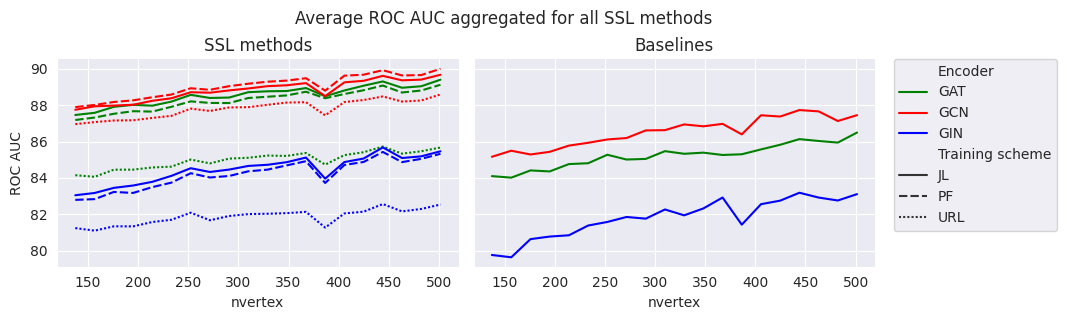

In [32]:
plot_aggregated_param_performance(df_marg = df_plot, param="nvertex")

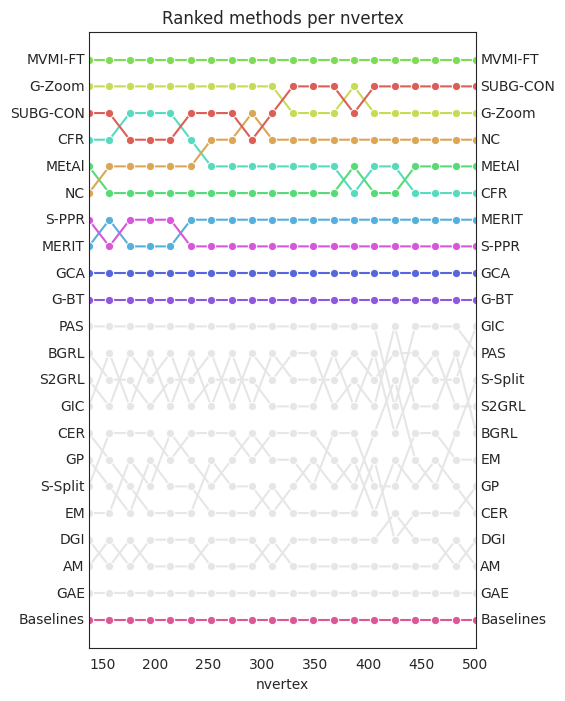

In [33]:
plot_ranks(interesting_methods = ["SUBG-CON","NC","G-Zoom","MVMI-FT","MEtAl","CFR","MERIT","GCA","G-BT","S-PPR", "Baselines"], 
           param ='nvertex')

0.27684516 [87.07445685]
0.2703216 [86.6748149]
0.23918986 [87.24410931]
0.2951749 [87.82921765]
0.081731066 [79.02851379]
0.20492963 [81.40160482]


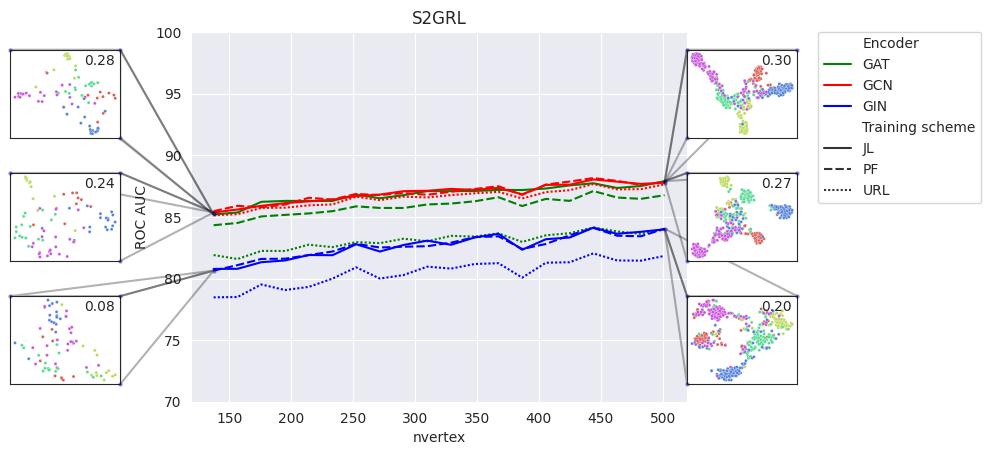

0.6344992 [98.58053974]
0.532989 [93.66101054]
0.49180877 [95.669033]
0.3352976 [89.66186401]
0.21279259 [82.53919512]
0.2200118 [83.05835829]


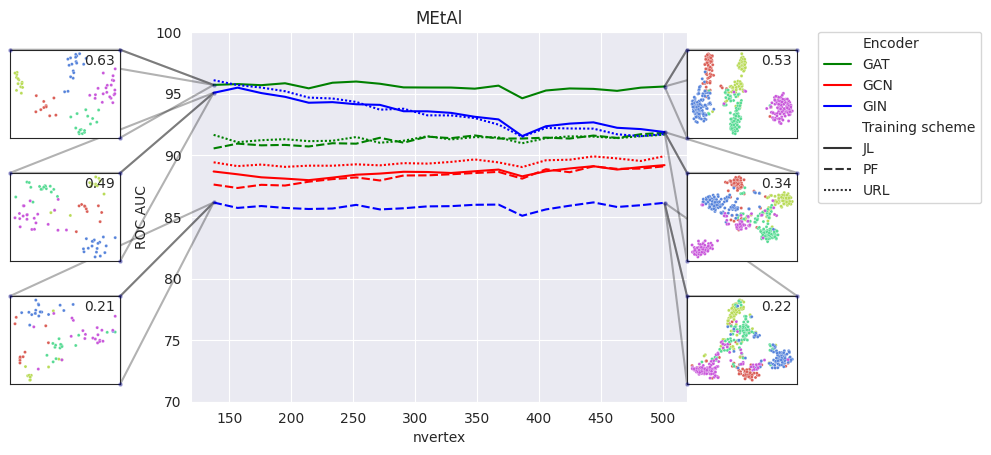

0.023675784 [68.15997974]
0.015957614 [70.9839511]
0.16811946 [82.83200105]
0.28653318 [89.6564741]
0.115392365 [83.19748271]
0.11429251 [81.5690314]


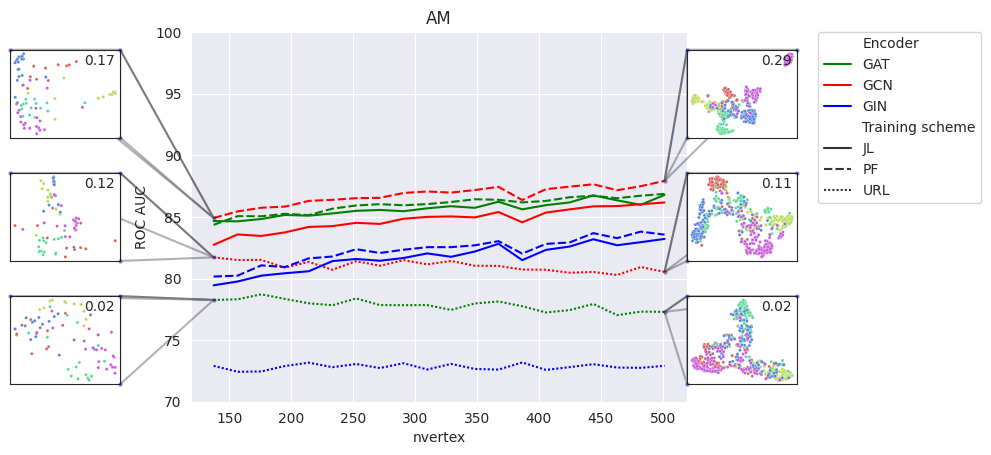

In [64]:
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_nvertex, method="S2GRL", param = "nvertex", 
                                          filter_e_ts={("GCN", "JL"):(1,0),("GAT", "JL"):(0,1), ("GIN", "PF"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(70, 100), yticks=[70, 75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_nvertex, method="MEtAl", param = "nvertex", 
                                          filter_e_ts={("GIN", "JL"):(1,1),("GAT", "JL"):(0,0),("GIN", "PF"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(70, 100), yticks=[70, 75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_nvertex, method="AM", param = "nvertex", 
                                          filter_e_ts={("GCN", "PF"):(0,0), ("GCN", "URL"):(1,1), ("GAT", "URL"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(70, 100), yticks=[70, 75, 80, 85, 90, 95, 100])
plt.show()

#### p to q ratio

In [65]:
df_p_to_q_ratio = get_embeddings_df('embeddings_p_to_q_ratio', param="p to q ratio", perplexity=50)

1.ndjson
2.ndjson
concatenating


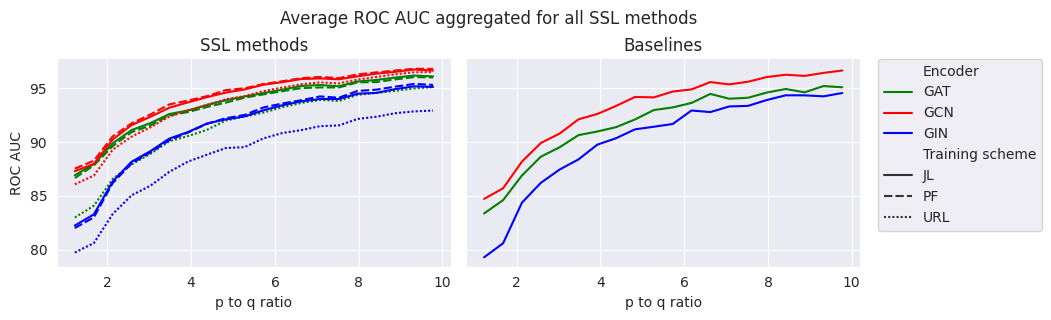

In [34]:
plot_aggregated_param_performance(df_marg = df_plot, param="p to q ratio")

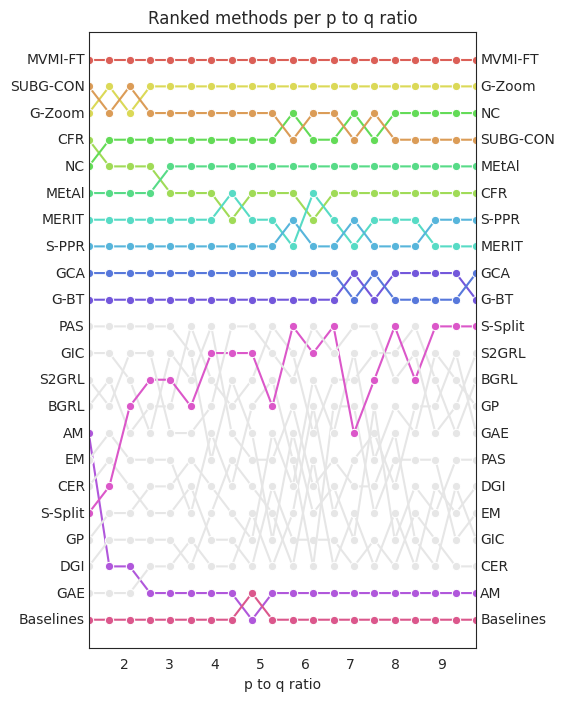

In [40]:
plot_ranks(interesting_methods = ["MVMI-FT","SUBG-CON","G-Zoom","CFR","NC","MEtAl","MERIT","S-PPR","GCA","G-BT","AM","S-Split","Baselines"], 
           param ='p to q ratio')

0.20370515 [81.46825548]
0.598609 [94.56916659]
0.2444228 [84.11926563]
0.6569949 [97.33457458]
0.0593272 [80.30954875]
0.4038835 [88.0025521]


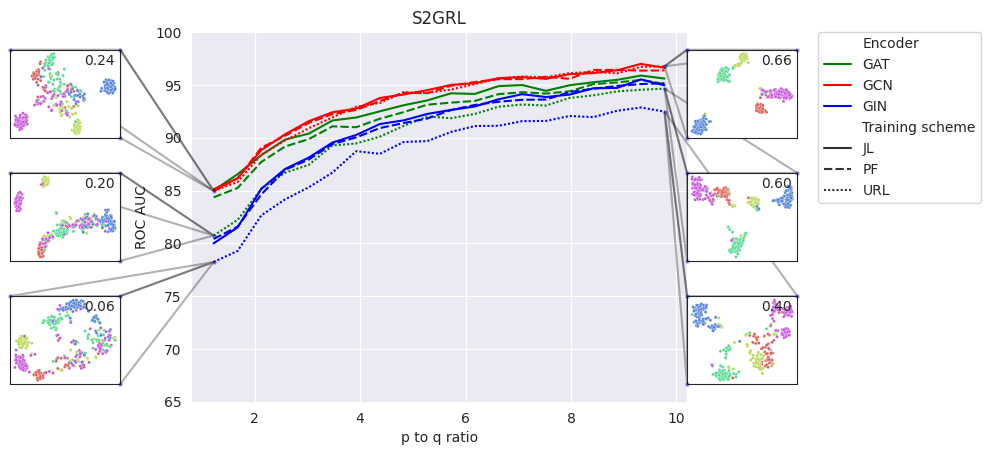

0.1154842 [80.27213162]
0.6818358 [96.84296465]
0.22440983 [86.2303879]
0.56352705 [95.39719518]
-0.028194945 [64.1729114]
0.4663923 [94.83901479]


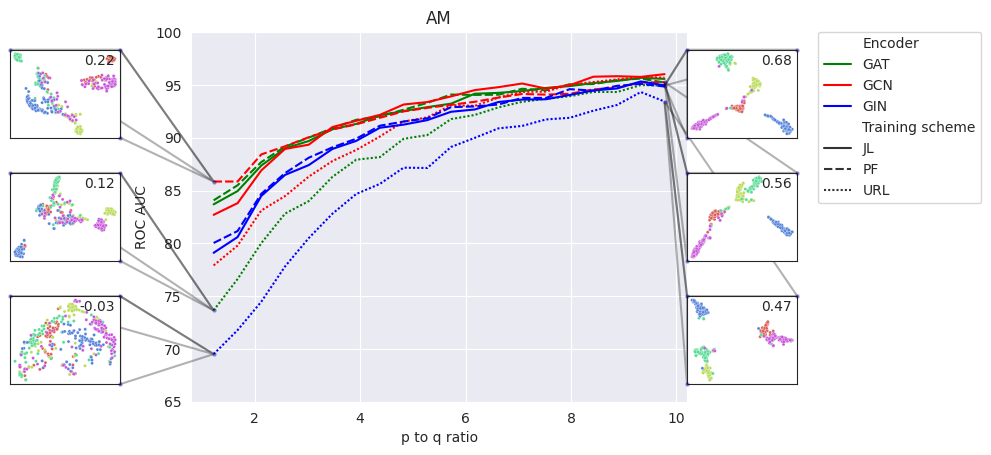

0.13301778 [79.23290465]
0.6493728 [96.18741821]
0.6392121 [95.36927866]
0.65839255 [95.97137908]


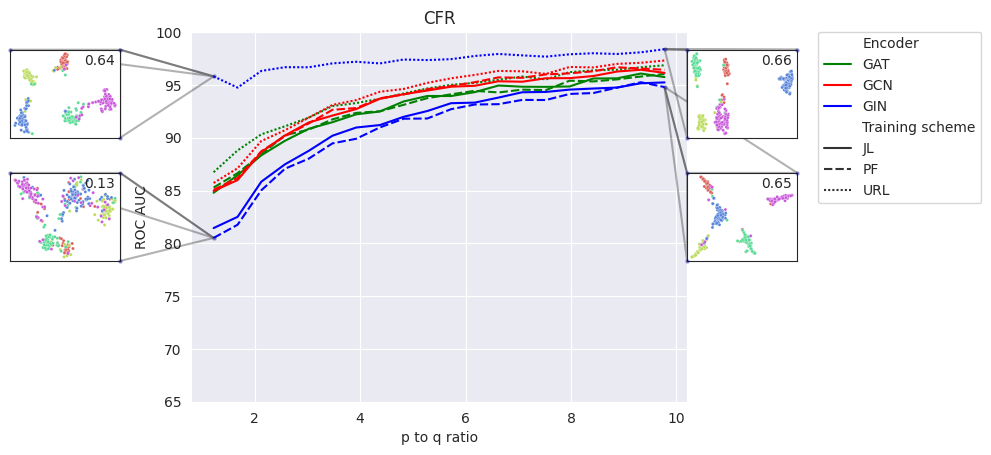

In [74]:
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_p_to_q_ratio, method="S2GRL", param = "p to q ratio", 
                                          filter_e_ts={("GCN", "URL"):(0,0),("GAT", "URL"):(1,1), ("GIN", "URL"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(65, 100), yticks=[65, 70, 75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_p_to_q_ratio, method="AM", param = "p to q ratio", 
                                          filter_e_ts={("GCN", "PF"):(0,1),("GAT", "URL"):(1,0), ("GIN", "URL"):(2,2)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(65, 100), yticks=[65, 70, 75, 80, 85, 90, 95, 100])
plt.show()
plot_marginalization_with_embeddings(df_marg = df_plot, df_embed = df_p_to_q_ratio, method="CFR", param = "p to q ratio", 
                                          filter_e_ts={("GIN", "URL"):(0,0), ("GIN", "PF"):(1,1)}, 
                                          remove_embed_values=[], draw_legend=True, ylim=(65, 100), yticks=[65, 70, 75, 80, 85, 90, 95, 100])
plt.show()

#### power exponent

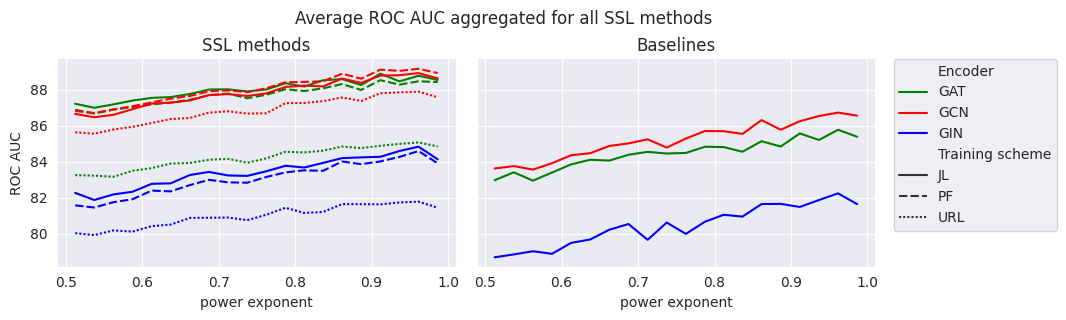

In [41]:
plot_aggregated_param_performance(df_marg = df_plot, param="power exponent")

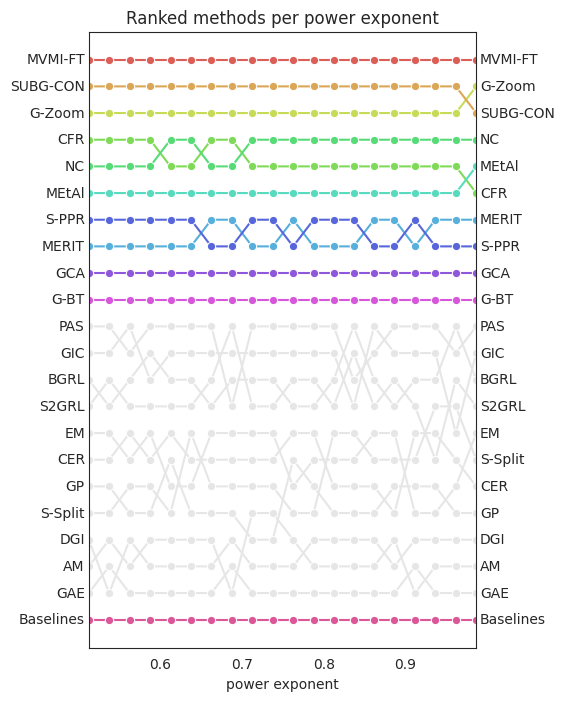

In [43]:
plot_ranks(interesting_methods = ["MVMI-FT","SUBG-CON","G-Zoom","CFR","NC","MEtAl","MERIT","S-PPR","GCA","G-BT","Baselines"], 
           param ='power exponent')